# Sistema de Recomendação de Cartões de Crédito

Este notebook tem como objetivo:

1. Desenvolver um modelo preditivo para classificação do principal cartão para clientes
2. Aplicar o modelo de clientes na base prospects
3. Gerar arquivo final com cartão ideal (recomendação) para prospects

### Importar bibliotecas necessárias

In [1]:
# EDA e Visualização de Dados
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway
from colorama import Fore, Back, Style

# Configurar formato de exibição para não usar notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True, precision=5)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from catboost import CatBoostClassifier, Pool, cv

# Otimização
import optuna

# Utilitários
import joblib

/home/emerson/.local/share/virtualenvs/final_challenge-EoF2KZun/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Abrir Base Clientes

In [2]:
df_clientes = pd.read_csv('./dataset/clientes.csv')

In [3]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Cliente                   1000 non-null   object 
 1   Nome                         1000 non-null   object 
 2   Idade                        1000 non-null   int64  
 3   Viagens                      1000 non-null   int64  
 4   Restaurantes                 1000 non-null   int64  
 5   Entretenimento               1000 non-null   int64  
 6   Cashback                     1000 non-null   int64  
 7   Compras online               1000 non-null   int64  
 8   Farmácias                    1000 non-null   int64  
 9   Programas de Milhagem        1000 non-null   int64  
 10  Postos de Combustível        1000 non-null   int64  
 11  Mercados                     1000 non-null   int64  
 12  Cidade                       1000 non-null   object 
 13  Cargo              

In [4]:
# Remover colunas únicas
df_clientes.drop(columns=['ID_Cliente', 'Nome'], axis=1, inplace=True)

In [5]:
num_vars = df_clientes.select_dtypes(include=['number']).columns
cat_vars = df_clientes.select_dtypes(exclude=['object']).columns
target = 'Principal Cartão'

### Testes de Hipóteses

In [6]:
# Testes de hipóteses entre Target Categórica e Numéricas (ANOVA)
for num_col in num_vars:
  groups = [df_clientes[df_clientes[target] == val][num_col] for val in df_clientes[target].unique()]
  stat, p = f_oneway(*groups)
  print(f"{Fore.RED if p < 0.05 else Fore.WHITE}"
        f"ANOVA entre {num_col} e {target}: p-valor = {p}")

ANOVA entre Idade e Principal Cartão: p-valor = 0.02334622684107804
ANOVA entre Viagens e Principal Cartão: p-valor = 4.59308651849609e-78
ANOVA entre Restaurantes e Principal Cartão: p-valor = 6.679790462858737e-13
ANOVA entre Entretenimento e Principal Cartão: p-valor = 5.089212006248722e-18
ANOVA entre Cashback e Principal Cartão: p-valor = 8.77437441029354e-12
ANOVA entre Compras online e Principal Cartão: p-valor = 0.00717148660617559
ANOVA entre Farmácias e Principal Cartão: p-valor = 0.0006390735697304401
ANOVA entre Programas de Milhagem e Principal Cartão: p-valor = 0.001269305962592174
ANOVA entre Postos de Combustível e Principal Cartão: p-valor = 0.11255638879254316
ANOVA entre Mercados e Principal Cartão: p-valor = 0.034152908342727085
ANOVA entre Tempo na Empresa e Principal Cartão: p-valor = 0.3209237036500026
ANOVA entre Pessoas em Casa e Principal Cartão: p-valor = 0.05946641455988785
ANOVA entre Renda e Principal Cartão: p-valor = 1.5360217142979344e-34
ANOVA entre In

In [7]:
# Analisando relação entre variáveis explicativas e targets
for col in num_vars:
  fig = px.box(df_clientes, x=target, y=col, title=f"{col} por {target}")
  fig.show()

for col in cat_vars:
  fig = px.histogram(df_clientes, x=col, color=target, title=f"{col} por {target}")
  fig.show()

### Modelo Catboost com Validação Cruzada

In [ ]:
selected_features = ['Viagens', 'Restaurantes', 'Entretenimento', 'Cashback', 'Compras online', 'Farmácias', 'Programas de Milhagem', 'Postos de Combustível', 'Mercados', 'Score']
X = df_clientes[selected_features]
y = df_clientes[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

params = {
  'iterations': 1000,
  'learning_rate': 0.05,
  'depth': 6,
  'l2_leaf_reg': 3,
  'random_strength': 2,
  'loss_function': 'MultiClass',
  'eval_metric': 'MultiClass',
}

model = CatBoostClassifier(**params, random_seed=42, auto_class_weights='Balanced')

model.fit(X_train, y_train)
# Obter o log loss médio
best_score = model.best_score_['learn']['MultiClass']
print(f"LogLoss no treinamento: {best_score}")

0:	learn: 3.1361616	total: 5.11ms	remaining: 5.11s
1:	learn: 3.0966905	total: 10ms	remaining: 5.01s
2:	learn: 3.0415708	total: 14.2ms	remaining: 4.73s
3:	learn: 2.9918112	total: 19.4ms	remaining: 4.82s
4:	learn: 2.9479092	total: 24.2ms	remaining: 4.81s
5:	learn: 2.9060745	total: 29.4ms	remaining: 4.87s
6:	learn: 2.8958633	total: 30.5ms	remaining: 4.33s
7:	learn: 2.8461542	total: 37.6ms	remaining: 4.66s
8:	learn: 2.8098443	total: 43.8ms	remaining: 4.82s
9:	learn: 2.7748998	total: 49.2ms	remaining: 4.87s
10:	learn: 2.7366319	total: 55ms	remaining: 4.94s
11:	learn: 2.7120453	total: 60.6ms	remaining: 4.99s
12:	learn: 2.6740911	total: 64.4ms	remaining: 4.89s
13:	learn: 2.6420074	total: 66.9ms	remaining: 4.71s
14:	learn: 2.6062796	total: 71.7ms	remaining: 4.71s
15:	learn: 2.5769803	total: 79.1ms	remaining: 4.87s
16:	learn: 2.5486886	total: 84.8ms	remaining: 4.9s
17:	learn: 2.5133635	total: 89.4ms	remaining: 4.88s
18:	learn: 2.4873181	total: 93.6ms	remaining: 4.83s
19:	learn: 2.4615481	total:

In [10]:
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
test_loss = log_loss(y_test, probs)
print(f"LogLoss no conjunto de teste: {test_loss:.2f}")

LogLoss no conjunto de teste: 1.46


### Otimizar com Optuna

In [12]:
# Definir a função objetivo para otimização
def objective(trial):
  # Definir o espaço de busca para os hiperparâmetros
  params = {
    'iterations': trial.suggest_int('iterations', 100, 1000),
    'depth': trial.suggest_int('depth', 4, 10),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
    'random_strength': trial.suggest_uniform('random_strength', 0, 10),
    'loss_function': 'MultiClass',
    'eval_metric': 'MultiClass',
  }

  model = CatBoostClassifier(**params, random_seed=42, auto_class_weights='Balanced')

  model.fit(X_train, y_train)
  best_score = model.best_score_['learn']['MultiClass']

  return best_score

# Criar um estudo e otimizar
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Ajuste o número de trials conforme necessário

# Obter os melhores parâmetros
best_params = study.best_params
best_metric = study.best_value
print("Melhores parâmetros:", best_params)
print("Melhor métrica:", best_metric)

[I 2025-04-07 17:41:56,706] A new study created in memory with name: no-name-1f3e6b8e-9a99-4a45-a540-b8fbaebf3674
/tmp/ipykernel_139545/3712176459.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipykernel_139545/3712176459.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipykernel_139545/3712176459.py:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



0:	learn: 3.1659433	total: 8.89ms	remaining: 5.93s
1:	learn: 3.1521961	total: 18.7ms	remaining: 6.21s
2:	learn: 3.1383738	total: 27ms	remaining: 5.98s
3:	learn: 3.1289289	total: 29.5ms	remaining: 4.9s
4:	learn: 3.1170917	total: 36.2ms	remaining: 4.8s
5:	learn: 3.1099365	total: 39.2ms	remaining: 4.33s
6:	learn: 3.0978852	total: 46.6ms	remaining: 4.4s
7:	learn: 3.0859774	total: 53.3ms	remaining: 4.39s
8:	learn: 3.0745901	total: 60.4ms	remaining: 4.42s
9:	learn: 3.0672160	total: 62.2ms	remaining: 4.09s
10:	learn: 3.0543067	total: 69.7ms	remaining: 4.16s
11:	learn: 3.0405316	total: 76.6ms	remaining: 4.19s
12:	learn: 3.0295533	total: 84ms	remaining: 4.23s
13:	learn: 3.0184914	total: 96ms	remaining: 4.49s
14:	learn: 3.0102713	total: 102ms	remaining: 4.45s
15:	learn: 3.0032443	total: 104ms	remaining: 4.25s
16:	learn: 2.9938668	total: 113ms	remaining: 4.32s
17:	learn: 2.9835176	total: 122ms	remaining: 4.39s
18:	learn: 2.9712173	total: 128ms	remaining: 4.37s
19:	learn: 2.9614743	total: 135ms	re

[I 2025-04-07 17:42:00,976] Trial 0 finished with value: 0.7392899120415759 and parameters: {'iterations': 668, 'depth': 7, 'learning_rate': 0.013524707324384308, 'l2_leaf_reg': 3.3440305183024903, 'random_strength': 4.492895381333222}. Best is trial 0 with value: 0.7392899120415759.


646:	learn: 0.7751505	total: 4.02s	remaining: 131ms
647:	learn: 0.7726376	total: 4.03s	remaining: 124ms
648:	learn: 0.7713364	total: 4.04s	remaining: 118ms
649:	learn: 0.7702188	total: 4.04s	remaining: 112ms
650:	learn: 0.7686782	total: 4.05s	remaining: 106ms
651:	learn: 0.7670842	total: 4.05s	remaining: 99.5ms
652:	learn: 0.7651277	total: 4.06s	remaining: 93.3ms
653:	learn: 0.7640827	total: 4.07s	remaining: 87.1ms
654:	learn: 0.7623226	total: 4.08s	remaining: 80.9ms
655:	learn: 0.7608140	total: 4.08s	remaining: 74.7ms
656:	learn: 0.7590846	total: 4.09s	remaining: 68.5ms
657:	learn: 0.7572035	total: 4.1s	remaining: 62.3ms
658:	learn: 0.7556558	total: 4.1s	remaining: 56ms
659:	learn: 0.7543929	total: 4.11s	remaining: 49.8ms
660:	learn: 0.7526780	total: 4.12s	remaining: 43.6ms
661:	learn: 0.7513232	total: 4.12s	remaining: 37.4ms
662:	learn: 0.7494096	total: 4.13s	remaining: 31.1ms
663:	learn: 0.7475435	total: 4.14s	remaining: 24.9ms
664:	learn: 0.7457255	total: 4.14s	remaining: 18.7ms
66

[I 2025-04-07 17:42:01,438] Trial 1 finished with value: 0.6210180148882742 and parameters: {'iterations': 302, 'depth': 4, 'learning_rate': 0.04998350159375929, 'l2_leaf_reg': 5.1863677224788844, 'random_strength': 7.978806818807057}. Best is trial 1 with value: 0.6210180148882742.


284:	learn: 0.6523632	total: 409ms	remaining: 24.4ms
285:	learn: 0.6495465	total: 410ms	remaining: 23ms
286:	learn: 0.6477521	total: 412ms	remaining: 21.5ms
287:	learn: 0.6455247	total: 413ms	remaining: 20.1ms
288:	learn: 0.6431577	total: 414ms	remaining: 18.6ms
289:	learn: 0.6415560	total: 415ms	remaining: 17.2ms
290:	learn: 0.6396812	total: 417ms	remaining: 15.8ms
291:	learn: 0.6381211	total: 418ms	remaining: 14.3ms
292:	learn: 0.6364504	total: 420ms	remaining: 12.9ms
293:	learn: 0.6344617	total: 421ms	remaining: 11.5ms
294:	learn: 0.6329205	total: 423ms	remaining: 10ms
295:	learn: 0.6307358	total: 424ms	remaining: 8.59ms
296:	learn: 0.6290024	total: 425ms	remaining: 7.16ms
297:	learn: 0.6274256	total: 427ms	remaining: 5.73ms
298:	learn: 0.6256926	total: 428ms	remaining: 4.29ms
299:	learn: 0.6240314	total: 430ms	remaining: 2.86ms
300:	learn: 0.6223758	total: 431ms	remaining: 1.43ms
301:	learn: 0.6210180	total: 433ms	remaining: 0us
0:	learn: 3.1666870	total: 30.4ms	remaining: 16.7s
1:

[I 2025-04-07 17:42:11,712] Trial 2 finished with value: 1.081050537155888 and parameters: {'iterations': 552, 'depth': 9, 'learning_rate': 0.011684775765586774, 'l2_leaf_reg': 3.3487652232026384, 'random_strength': 7.5392266153296985}. Best is trial 1 with value: 0.6210180148882742.


551:	learn: 1.0810505	total: 10.2s	remaining: 0us
0:	learn: 3.1669861	total: 35.2ms	remaining: 11.5s
1:	learn: 3.1553081	total: 76ms	remaining: 12.4s
2:	learn: 3.1443539	total: 95.9ms	remaining: 10.4s
3:	learn: 3.1339295	total: 105ms	remaining: 8.44s
4:	learn: 3.1238882	total: 107ms	remaining: 6.91s
5:	learn: 3.1127339	total: 136ms	remaining: 7.26s
6:	learn: 3.1018176	total: 165ms	remaining: 7.53s
7:	learn: 3.0913670	total: 196ms	remaining: 7.83s
8:	learn: 3.0802461	total: 205ms	remaining: 7.24s
9:	learn: 3.0671226	total: 221ms	remaining: 7.01s
10:	learn: 3.0553160	total: 252ms	remaining: 7.25s
11:	learn: 3.0447325	total: 279ms	remaining: 7.33s
12:	learn: 3.0376717	total: 281ms	remaining: 6.78s
13:	learn: 3.0276162	total: 306ms	remaining: 6.85s
14:	learn: 3.0173677	total: 332ms	remaining: 6.91s
15:	learn: 3.0066432	total: 358ms	remaining: 6.96s
16:	learn: 2.9946029	total: 385ms	remaining: 7.02s
17:	learn: 2.9843017	total: 414ms	remaining: 7.1s
18:	learn: 2.9740329	total: 445ms	remainin

[I 2025-04-07 17:42:18,894] Trial 3 finished with value: 1.4530462275745848 and parameters: {'iterations': 327, 'depth': 9, 'learning_rate': 0.024586691291498524, 'l2_leaf_reg': 8.06653910250924, 'random_strength': 1.978868619499915}. Best is trial 1 with value: 0.6210180148882742.


0:	learn: 3.1249848	total: 7.76ms	remaining: 5.52s
1:	learn: 3.0653565	total: 16.2ms	remaining: 5.74s
2:	learn: 3.0085730	total: 24.9ms	remaining: 5.88s
3:	learn: 2.9692105	total: 27.6ms	remaining: 4.88s
4:	learn: 2.9218370	total: 36.5ms	remaining: 5.16s
5:	learn: 2.8924069	total: 38.7ms	remaining: 4.55s
6:	learn: 2.8483631	total: 47.3ms	remaining: 4.77s
7:	learn: 2.8060839	total: 54.2ms	remaining: 4.77s
8:	learn: 2.7659316	total: 62.6ms	remaining: 4.89s
9:	learn: 2.7386365	total: 64.1ms	remaining: 4.5s
10:	learn: 2.6953056	total: 72.9ms	remaining: 4.64s
11:	learn: 2.6501030	total: 80.9ms	remaining: 4.72s
12:	learn: 2.6154550	total: 89ms	remaining: 4.79s
13:	learn: 2.5814292	total: 97.2ms	remaining: 4.85s
14:	learn: 2.5557988	total: 101ms	remaining: 4.69s
15:	learn: 2.5321375	total: 102ms	remaining: 4.45s
16:	learn: 2.5051629	total: 110ms	remaining: 4.49s
17:	learn: 2.4760145	total: 116ms	remaining: 4.49s
18:	learn: 2.4381971	total: 123ms	remaining: 4.5s
19:	learn: 2.4112064	total: 131

[I 2025-04-07 17:42:24,081] Trial 4 finished with value: 0.11403749579457269 and parameters: {'iterations': 712, 'depth': 7, 'learning_rate': 0.07758341177952367, 'l2_leaf_reg': 4.674250436818806, 'random_strength': 6.096421516244705}. Best is trial 4 with value: 0.11403749579457269.


704:	learn: 0.1153532	total: 5.01s	remaining: 49.8ms
705:	learn: 0.1151601	total: 5.02s	remaining: 42.7ms
706:	learn: 0.1149599	total: 5.03s	remaining: 35.6ms
707:	learn: 0.1147706	total: 5.04s	remaining: 28.5ms
708:	learn: 0.1145774	total: 5.04s	remaining: 21.3ms
709:	learn: 0.1144164	total: 5.05s	remaining: 14.2ms
710:	learn: 0.1142235	total: 5.06s	remaining: 7.12ms
711:	learn: 0.1140375	total: 5.07s	remaining: 0us
0:	learn: 3.1627764	total: 3.62ms	remaining: 2.87s
1:	learn: 3.1466916	total: 7.29ms	remaining: 2.88s
2:	learn: 3.1252814	total: 12.1ms	remaining: 3.18s
3:	learn: 3.1065205	total: 16.7ms	remaining: 3.3s
4:	learn: 3.0897568	total: 20.8ms	remaining: 3.27s
5:	learn: 3.0733061	total: 24.4ms	remaining: 3.2s
6:	learn: 3.0685860	total: 25.7ms	remaining: 2.88s
7:	learn: 3.0474423	total: 28.6ms	remaining: 2.8s
8:	learn: 3.0316020	total: 33.4ms	remaining: 2.91s
9:	learn: 3.0171773	total: 36.9ms	remaining: 2.89s
10:	learn: 2.9991626	total: 42.1ms	remaining: 2.99s
11:	learn: 2.9936664

[I 2025-04-07 17:42:27,190] Trial 5 finished with value: 0.36563576623866473 and parameters: {'iterations': 793, 'depth': 6, 'learning_rate': 0.0406191015157519, 'l2_leaf_reg': 8.62816798620777, 'random_strength': 4.534538740815823}. Best is trial 4 with value: 0.11403749579457269.


757:	learn: 0.3804940	total: 2.89s	remaining: 133ms
758:	learn: 0.3800449	total: 2.89s	remaining: 129ms
759:	learn: 0.3795972	total: 2.89s	remaining: 126ms
760:	learn: 0.3791836	total: 2.9s	remaining: 122ms
761:	learn: 0.3787736	total: 2.9s	remaining: 118ms
762:	learn: 0.3783483	total: 2.91s	remaining: 114ms
763:	learn: 0.3779379	total: 2.91s	remaining: 110ms
764:	learn: 0.3774320	total: 2.91s	remaining: 107ms
765:	learn: 0.3769771	total: 2.92s	remaining: 103ms
766:	learn: 0.3765411	total: 2.92s	remaining: 99ms
767:	learn: 0.3761929	total: 2.92s	remaining: 95.2ms
768:	learn: 0.3757872	total: 2.93s	remaining: 91.4ms
769:	learn: 0.3753156	total: 2.93s	remaining: 87.6ms
770:	learn: 0.3749032	total: 2.94s	remaining: 83.8ms
771:	learn: 0.3744353	total: 2.94s	remaining: 80ms
772:	learn: 0.3739912	total: 2.94s	remaining: 76.1ms
773:	learn: 0.3735761	total: 2.95s	remaining: 72.3ms
774:	learn: 0.3731903	total: 2.95s	remaining: 68.5ms
775:	learn: 0.3727341	total: 2.95s	remaining: 64.7ms
776:	lea

[I 2025-04-07 17:42:30,894] Trial 6 finished with value: 0.1635406858982043 and parameters: {'iterations': 281, 'depth': 8, 'learning_rate': 0.07020045160871285, 'l2_leaf_reg': 1.9672560819910792, 'random_strength': 6.1096601312648176}. Best is trial 4 with value: 0.11403749579457269.


274:	learn: 0.1681642	total: 3.55s	remaining: 77.5ms
275:	learn: 0.1673504	total: 3.57s	remaining: 64.6ms
276:	learn: 0.1664805	total: 3.58s	remaining: 51.7ms
277:	learn: 0.1657341	total: 3.6s	remaining: 38.8ms
278:	learn: 0.1649826	total: 3.61s	remaining: 25.9ms
279:	learn: 0.1642784	total: 3.62s	remaining: 12.9ms
280:	learn: 0.1635407	total: 3.63s	remaining: 0us
0:	learn: 3.0851804	total: 6.4ms	remaining: 941ms
1:	learn: 2.9897849	total: 16ms	remaining: 1.17s
2:	learn: 2.8961578	total: 23.7ms	remaining: 1.15s
3:	learn: 2.8421732	total: 26.4ms	remaining: 951ms
4:	learn: 2.7706466	total: 34.5ms	remaining: 987ms
5:	learn: 2.7320454	total: 37.4ms	remaining: 886ms
6:	learn: 2.6684870	total: 45.4ms	remaining: 915ms
7:	learn: 2.6056154	total: 53.4ms	remaining: 934ms
8:	learn: 2.5475942	total: 61.6ms	remaining: 951ms
9:	learn: 2.5160428	total: 63.1ms	remaining: 871ms
10:	learn: 2.4582047	total: 71.2ms	remaining: 887ms
11:	learn: 2.3929261	total: 78.9ms	remaining: 894ms
12:	learn: 2.3461292	t

[I 2025-04-07 17:42:31,899] Trial 7 finished with value: 0.38320134584836335 and parameters: {'iterations': 148, 'depth': 7, 'learning_rate': 0.06846786523982357, 'l2_leaf_reg': 1.840327848189237, 'random_strength': 4.050963745627932}. Best is trial 4 with value: 0.11403749579457269.


136:	learn: 0.4407675	total: 894ms	remaining: 71.8ms
137:	learn: 0.4347135	total: 901ms	remaining: 65.3ms
138:	learn: 0.4295865	total: 908ms	remaining: 58.8ms
139:	learn: 0.4241382	total: 916ms	remaining: 52.4ms
140:	learn: 0.4188231	total: 924ms	remaining: 45.9ms
141:	learn: 0.4138789	total: 932ms	remaining: 39.4ms
142:	learn: 0.4068116	total: 938ms	remaining: 32.8ms
143:	learn: 0.4020840	total: 945ms	remaining: 26.2ms
144:	learn: 0.3965555	total: 951ms	remaining: 19.7ms
145:	learn: 0.3909564	total: 958ms	remaining: 13.1ms
146:	learn: 0.3877937	total: 965ms	remaining: 6.57ms
147:	learn: 0.3832013	total: 973ms	remaining: 0us
0:	learn: 3.1664228	total: 3.53ms	remaining: 960ms
1:	learn: 3.1550876	total: 7.59ms	remaining: 1.03s
2:	learn: 3.1392375	total: 11.8ms	remaining: 1.06s
3:	learn: 3.1246693	total: 16.1ms	remaining: 1.08s
4:	learn: 3.1116192	total: 20.6ms	remaining: 1.1s
5:	learn: 3.0988472	total: 24ms	remaining: 1.07s
6:	learn: 3.0957296	total: 25ms	remaining: 950ms
7:	learn: 3.082

[I 2025-04-07 17:42:32,905] Trial 8 finished with value: 1.5169125395886227 and parameters: {'iterations': 273, 'depth': 6, 'learning_rate': 0.016120158405419586, 'l2_leaf_reg': 3.749048776053615, 'random_strength': 6.647033925649434}. Best is trial 4 with value: 0.11403749579457269.


251:	learn: 1.5849028	total: 897ms	remaining: 74.8ms
252:	learn: 1.5816985	total: 901ms	remaining: 71.2ms
253:	learn: 1.5786737	total: 905ms	remaining: 67.7ms
254:	learn: 1.5770608	total: 906ms	remaining: 63.9ms
255:	learn: 1.5719206	total: 910ms	remaining: 60.4ms
256:	learn: 1.5708669	total: 911ms	remaining: 56.7ms
257:	learn: 1.5693057	total: 912ms	remaining: 53ms
258:	learn: 1.5656249	total: 916ms	remaining: 49.5ms
259:	learn: 1.5621040	total: 920ms	remaining: 46ms
260:	learn: 1.5587554	total: 924ms	remaining: 42.5ms
261:	learn: 1.5547839	total: 927ms	remaining: 38.9ms
262:	learn: 1.5506205	total: 931ms	remaining: 35.4ms
263:	learn: 1.5465651	total: 935ms	remaining: 31.9ms
264:	learn: 1.5434326	total: 939ms	remaining: 28.3ms
265:	learn: 1.5407036	total: 943ms	remaining: 24.8ms
266:	learn: 1.5370472	total: 947ms	remaining: 21.3ms
267:	learn: 1.5343732	total: 951ms	remaining: 17.7ms
268:	learn: 1.5315059	total: 954ms	remaining: 14.2ms
269:	learn: 1.5283217	total: 958ms	remaining: 10.6

[I 2025-04-07 17:42:33,239] Trial 9 finished with value: 1.2585278200246262 and parameters: {'iterations': 135, 'depth': 5, 'learning_rate': 0.045940952428678086, 'l2_leaf_reg': 3.6747392205357063, 'random_strength': 8.820596182556953}. Best is trial 4 with value: 0.11403749579457269.


130:	learn: 1.2828820	total: 305ms	remaining: 9.3ms
131:	learn: 1.2779956	total: 307ms	remaining: 6.97ms
132:	learn: 1.2719649	total: 309ms	remaining: 4.65ms
133:	learn: 1.2643103	total: 312ms	remaining: 2.33ms
134:	learn: 1.2585278	total: 314ms	remaining: 0us
Melhores parâmetros: {'iterations': 712, 'depth': 7, 'learning_rate': 0.07758341177952367, 'l2_leaf_reg': 4.674250436818806, 'random_strength': 6.096421516244705}
Melhor métrica: 0.11403749579457269


In [13]:
# Treinar o modelo final com os parâmetros otimizados
best_model = CatBoostClassifier(**best_params, verbose=False, random_seed=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)
test_loss = log_loss(y_test, probs)
print(f"LogLoss no conjunto de testes: {test_loss:.2f}")

LogLoss no conjunto de testes: 1.45



Relatório de Classificação:
                                         precision    recall  f1-score   support

       Rocketseat Mastercard Life Basic       0.46      0.37      0.41        79
       Rocketseat Mastercard Life Elite       0.50      0.35      0.41        17
    Rocketseat Mastercard Life Platinum       0.00      0.00      0.00         1
      Rocketseat Mastercard Life Select       0.52      0.48      0.50        25
   Rocketseat Mastercard Shopping Basic       0.40      0.55      0.46        40
   Rocketseat Mastercard Shopping Elite       0.43      0.43      0.43         7
Rocketseat Mastercard Shopping Platinum       0.00      0.00      0.00         2
  Rocketseat Mastercard Shopping Select       0.33      0.43      0.38        14
     Rocketseat Mastercard Travel Basic       0.47      0.71      0.57        45
     Rocketseat Mastercard Travel Elite       0.50      0.22      0.31         9
  Rocketseat Mastercard Travel Platinum       0.00      0.00      0.00         

/home/emerson/.local/share/virtualenvs/final_challenge-EoF2KZun/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/emerson/.local/share/virtualenvs/final_challenge-EoF2KZun/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/emerson/.local/share/virtualenvs/final_challenge-EoF2KZun/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



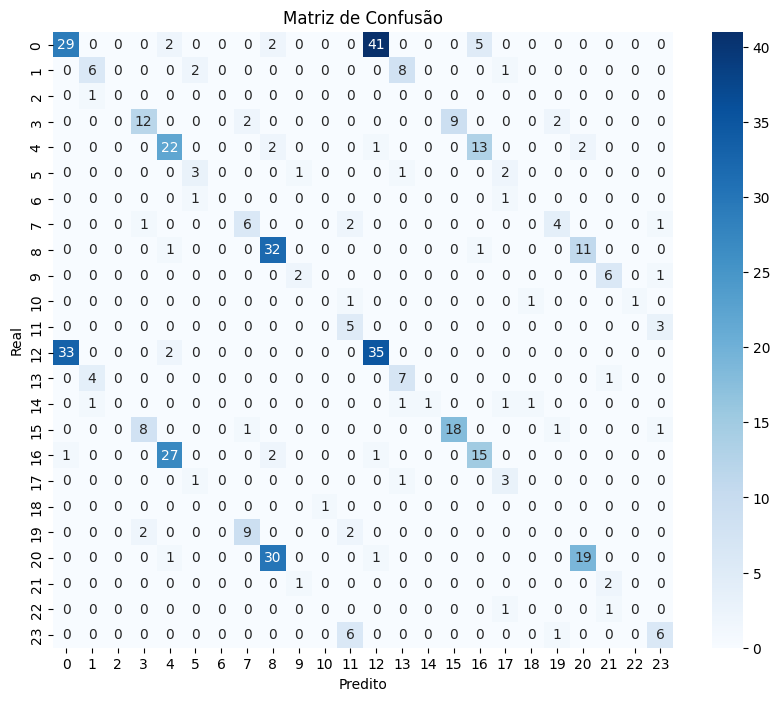

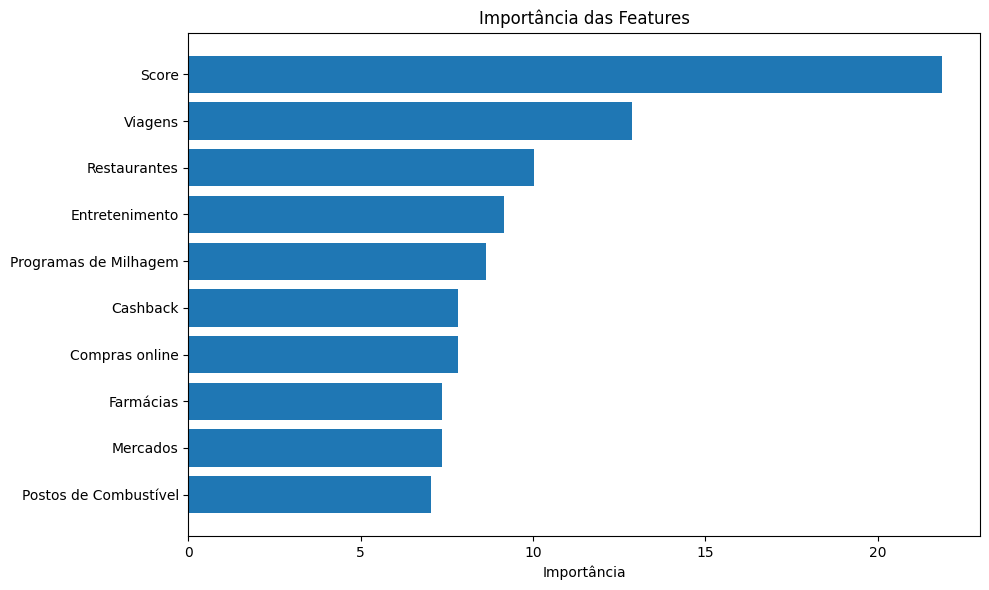

In [14]:
# Calcular e exibir métricas
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Criar matriz de confusão
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Plotar importância das features
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
  'feature': selected_features,
  'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Importância das Features')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

### Salvar Modelo

In [15]:
joblib.dump(best_model, 'modelo_recomendacao.pkl')

['modelo_recomendacao.pkl']